### 2.0 Keywords and Filtering
In this notebook, the texts are tokenized and lemmatized, in order to extract keywords and filter out religious decisions.

In [4]:
# Import packages
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import numpy as np
import re
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
import ast

import re
import nltk 
from nltk import word_tokenize
nltk.download("stopwords")
from nltk.probability import FreqDist

import spacy

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\25mad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# pip install tqdm
# pip install wordcloud

In [6]:
df = pd.read_csv("data/df_text_clean.csv")
df.head()

,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,registerzeichen,richter
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerden 1. des Herrn H. , 2...","['§ 2 Absatz 2 des Bundeswahlgesetzes, als dan...",die Verfassungsbeschwerden des Herrn des Herrn...,1951-09-09,1951,B,S,BvQ,Dr. Katz|Dr. Fröhlich|Wolff|Dr. Roediger|Dr. K...
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 189/09 -\n...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde 1. der Frau W…, 2. d...","['§ 93b in Verbindung mit § 93a BVerfGG', '§ 8...",die Verfassungsbeschwerde der Frau des Herrn d...,1952-09-10,1952,B,S,BvR,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Scheffle...
2,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvR 432/07 -\n...,https://www.bundesverfassungsgericht.de/Shared...,die Verfassungsbeschwerden des Herrn M... I. g...,"['§ 93b in Verbindung mit § 93a BVerfGG', 'Art...",die Verfassungsbeschwerden des Herrn gegen den...,1952-10-10,1952,B,S,BvR,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Heiland|...
3,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 2037/10 -\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde 1. der Frau L…, 2. d...","['§ 178a SGG', 'Art. 103 Abs. 1 GG', '§ 3 Abs....",die Verfassungsbeschwerde der Frau der Minderj...,1957-01-16,1957,U,S,BvR,Dr. Wintrich|Dr. Scheffler|Dr. Heiland|Dr. Hec...
4,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde der Frau R..., KÖRIN...","['§ 93b in Verbindung mit § 93a BVerfGG', '§ 5...",die Verfassungsbeschwerde der Frau KÖRING Rech...,1958-01-15,1958,U,S,BvR,NaN


In [7]:
df.dtypes

text                 object
url_html             object
clean_w_numbers      object
gesetzesverweise     object
clean_wo_numbers     object
datum                object
entscheidungsjahr     int64
entscheidung_typ     object
spruchkoerper_typ    object
registerzeichen      object
richter              object
dtype: object

In [8]:
df.isna().sum()

text                    0
url_html                0
clean_w_numbers         0
gesetzesverweise     1360
clean_wo_numbers        0
datum                   0
entscheidungsjahr       0
entscheidung_typ        0
spruchkoerper_typ       0
registerzeichen         0
richter                24
dtype: int64

In [9]:
# Change dtypes
df.loc[:, "datum"] = pd.to_datetime(df["datum"])

#### 1.1. Tokenization
In dieser Sektion werden die Texte von Punktuation und Stoppwörtern (generellen und selbst-festgelegten) befreit.

In [10]:
## Stopword lists
lst_stopwords = nltk.corpus.stopwords.words("german")
with open("extended_stopwords.txt", "r", encoding="utf-8") as f:
    custom_stopwords = set(f.read().splitlines())
with open("german_stopwords_full.txt", "r", encoding="utf-8") as f:
    german_stopwords_extended = set(f.read().splitlines())

# Function to remove punctuation and stopwords
def utils_preprocess_text_stopwords(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split() 
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in german_stopwords_extended and word not in lst_stopwords and word not in custom_stopwords]
    
    text = " ".join(lst_text)
    return text

In [11]:
df["processed_wo_numbers"] = df["clean_wo_numbers"].apply(utils_preprocess_text_stopwords)

#### 1.2. Lemmatization
Der von Stoppwörtern befreite Text wird anschließend lemmatisiert, um so besser nach Schlüsselbegriffen suchen zu können.

In [12]:
# Lemmatize words using spacy
nlp = spacy.load('de_core_news_sm')

lemma_text_list = []
for doc in tqdm(nlp.pipe(df["processed_wo_numbers"], disable=["parser", "ner"])):
    lemma_text_list.append(" ".join([token.lemma_ for token in doc]))
df["text_lemma"] = lemma_text_list

8949it [05:28, 27.20it/s]


In [13]:
df[["processed_wo_numbers", "text_lemma"]].head()

,processed_wo_numbers,text_lemma
0,verfassungsbeschwerden herrn herrn herrn josef...,verfassungsbeschwerd Herr Herr Herr Josef Herr...
1,verfassungsbeschwerde herrn joseph hessischen ...,Verfassungsbeschwerde Herr Joseph hessisch Ver...
2,verfassungsbeschwerden herrn bundesgerichtshof...,verfassungsbeschwerd Herr Bundesgerichtshof Ur...
3,verfassungsbeschwerde minderjährigen gesetzlic...,Verfassungsbeschwerde minderjährigen gesetzlic...
4,verfassungsbeschwerde köring rechtsanwälte ste...,Verfassungsbeschwerde Köring rechtsanwäln Steu...


#### 1.3 Reliöse Entscheidungen filtern
Um religöse Urteile erkennen zu können, wird durch eine vordefinierte Liste von religiösen Begriffen iteriert und gesucht. 

In [14]:
religious_keywords = ["glaubensfreiheit", "religiös", "religion", "religionsgemeinschaft", "religionsfreiheit",
                      "gott", "christentum", "kirche", "bibel",
                      "islam", "moschee", "kopftuch","koran",
                      "tora", "synagoge", 
                     ]

In [15]:
# Identify and count religious terms
def count_religious_terms(text, keywords):
    if not isinstance(text, str):
        return 0, {}
    
    text = text.lower()
    total_count = 0
    term_counts = {}
    
    for keyword in keywords:
        count = len(re.findall(r'\b' + keyword + r'\b', text))
        if count > 0:
            term_counts[keyword] = count
            total_count += count
    
    return total_count, term_counts

In [16]:
df[["religious_terms_count", "religious_terms_detail"]] = df["clean_wo_numbers"].apply(lambda x: pd.Series(count_religious_terms(x, religious_keywords)))
df["has_religious_content"] = df["religious_terms_count"] > 0

In [17]:
religious_percentage = df['has_religious_content'].mean() * 100
print(f"Anteil der Entscheidungen mit religiösem Bezug: {religious_percentage:.2f}%")
df[df["has_religious_content"] == True][["religious_terms_count", "religious_terms_detail", "has_religious_content"]].head(5) 

Anteil der Entscheidungen mit religiösem Bezug: 1.62%


,religious_terms_count,religious_terms_detail,has_religious_content
120,1,{'glaubensfreiheit': 1},True
277,1,{'gott': 1},True
307,1,{'religion': 1},True
388,1,{'religiös': 1},True
389,1,{'religiös': 1},True


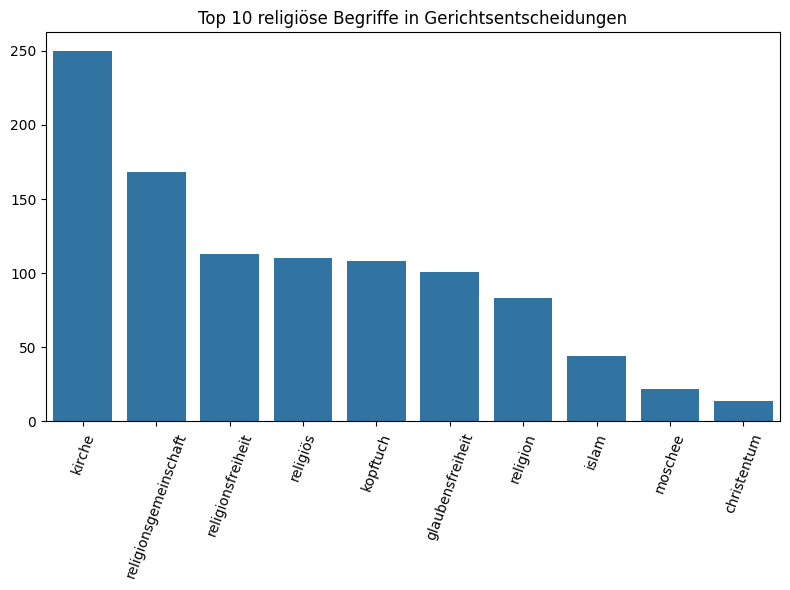

In [18]:
all_terms = Counter()
for terms_dict in df['religious_terms_detail'].dropna():
    all_terms.update(terms_dict)

plt.figure(figsize=(8, 6))
sns.barplot(x=list(dict(all_terms.most_common(10)).keys()),
            y=list(dict(all_terms.most_common(10)).values()))
plt.title('Top 10 religiöse Begriffe in Gerichtsentscheidungen')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

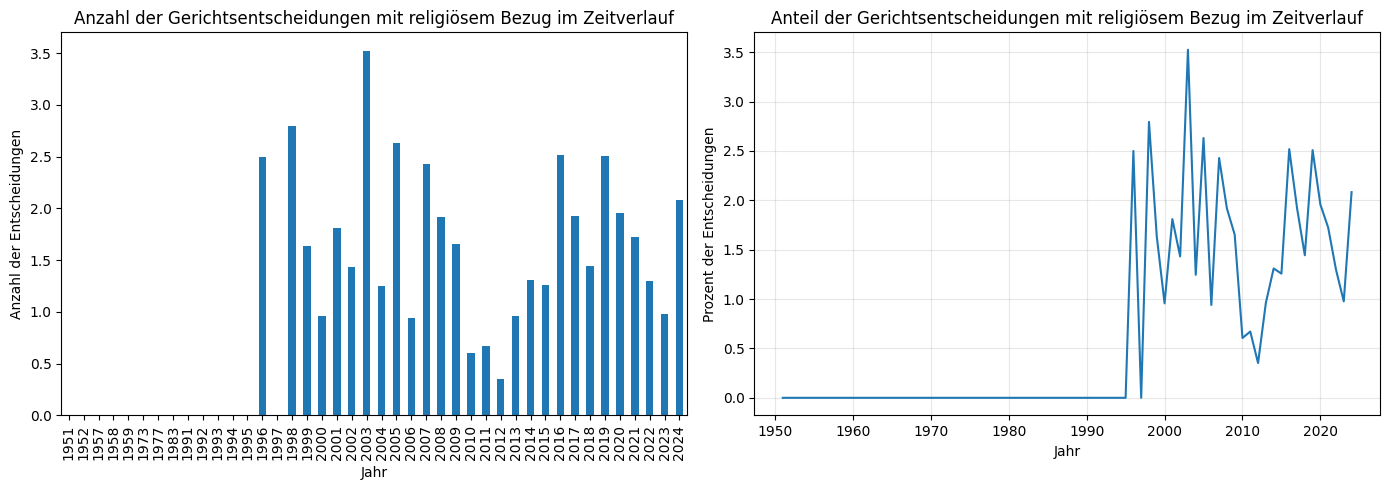

In [19]:
religion_by_year = df.groupby('entscheidungsjahr')['has_religious_content'].mean() * 100

fig, axs = plt.subplots(1, 2, figsize=(14,5))

religion_by_year.plot(kind="bar", ax=axs[0])
axs[0].set_title('Anzahl der Gerichtsentscheidungen mit religiösem Bezug im Zeitverlauf')
axs[0].set_xlabel('Jahr')
axs[0].set_ylabel('Anzahl der Entscheidungen')

religion_by_year.plot(kind='line', ax=axs[1])
axs[1].set_title('Anteil der Gerichtsentscheidungen mit religiösem Bezug im Zeitverlauf')
axs[1].set_xlabel('Jahr')
axs[1].set_ylabel('Prozent der Entscheidungen')
axs[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

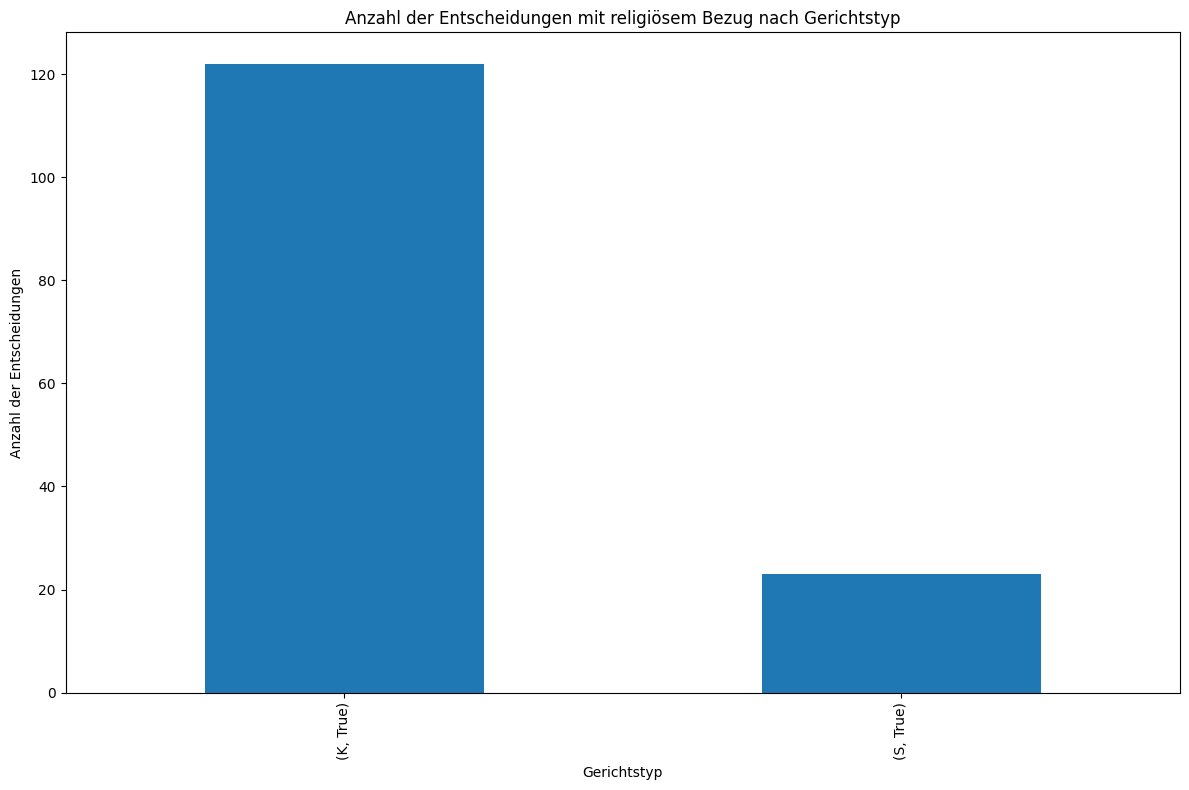

In [20]:
religion_by_court = df[df["has_religious_content"] == True].groupby('spruchkoerper_typ')['has_religious_content'].value_counts()

plt.figure(figsize=(12, 8))
religion_by_court.plot(kind='bar')
plt.title('Anzahl der Entscheidungen mit religiösem Bezug nach Gerichtstyp')
plt.xlabel('Gerichtstyp')
plt.ylabel('Anzahl der Entscheidungen')
plt.tight_layout()
plt.show()

Es fällt auf, dass die meisten Verfassungsbeschwerden innerhalb der Kammer abgehandelt wurden sind. Solche, die neue verfassungsrechtliche Fragen aufwerfen lassen, werden innerhalb des Senats behandelt, davon erscheint allerdings nur ein kleiner Pool vorhanden zu sein.

In [21]:
top_religious_cases = df.sort_values('religious_terms_count', ascending=False).head(10)
print("Top 10 Entscheidungen mit den meisten religiösen Bezügen:")
for idx, row in top_religious_cases.iterrows():
    print(f"Jahr: {row['entscheidungsjahr']}, Spruchkörper-Typ: {row['spruchkoerper_typ']}, Entscheidungs-Typ: {row['entscheidung_typ']} " 
          f"Religiöse Begriffe: {row['religious_terms_count']}")

Top 10 Entscheidungen mit den meisten religiösen Bezügen:
Jahr: 2016, Spruchkörper-Typ: S, Entscheidungs-Typ: B Religiöse Begriffe: 84
Jahr: 2004, Spruchkörper-Typ: S, Entscheidungs-Typ: B Religiöse Begriffe: 82
Jahr: 2020, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 80
Jahr: 2016, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 80
Jahr: 2001, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 51
Jahr: 2017, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 35
Jahr: 2016, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 32
Jahr: 1999, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 29
Jahr: 2017, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 29
Jahr: 2016, Spruchkörper-Typ: K, Entscheidungs-Typ: B Religiöse Begriffe: 28


Auffälligkeiten der aufgezählten Jahre:
- 2016; 3 Aufzählungen mit über 25 religiösen Begriffen, die genannt worden sind und einem Senats-Beschluss
- 2004; ein Beschluss innerhalb des Senats
- 2020; große Anzahl an religiösen Begriffen gefallen
- 2017; " + taucht zweimal auf
- 1999, 2001; auffällig von den anderen Daten abschweifend

In [22]:
# Based on keywords choose themes to visualize better trends
religion_themes = {
    'christentum': ['christentum', 'kirche', 'bibel', ],  
    'islam': ['islam', 'moschee', 'kopftuch', 'koran',],
    'judentum': ['judentum', 'tora', 'synagoge', ],
        # 'allgemein': ['glaubensfreiheit', 'religiös', 'religion', 'religionsgemeinschaft', 'religionsfreiheit', 'gott']
        # für ein genaueres Bild ausgeschlossen
}

In [23]:
for theme, keywords in religion_themes.items():
    df[f'has_{theme}'] = df['clean_wo_numbers'].apply(
        lambda x: 1 if isinstance(x, str) and any(re.search(r'\b' + k + r'\b', x.lower()) for k in keywords) else 0
    )

religion_comparison = {theme: df[f'has_{theme}'].mean() * 100 for theme in religion_themes.keys()}
print("Verteilung religiöser Themen in Prozent:")
for theme, percentage in religion_comparison.items():
    print(f"{theme}: {percentage:.2f}%")

Verteilung religiöser Themen in Prozent:
christentum: 0.75%
islam: 0.29%
judentum: 0.09%


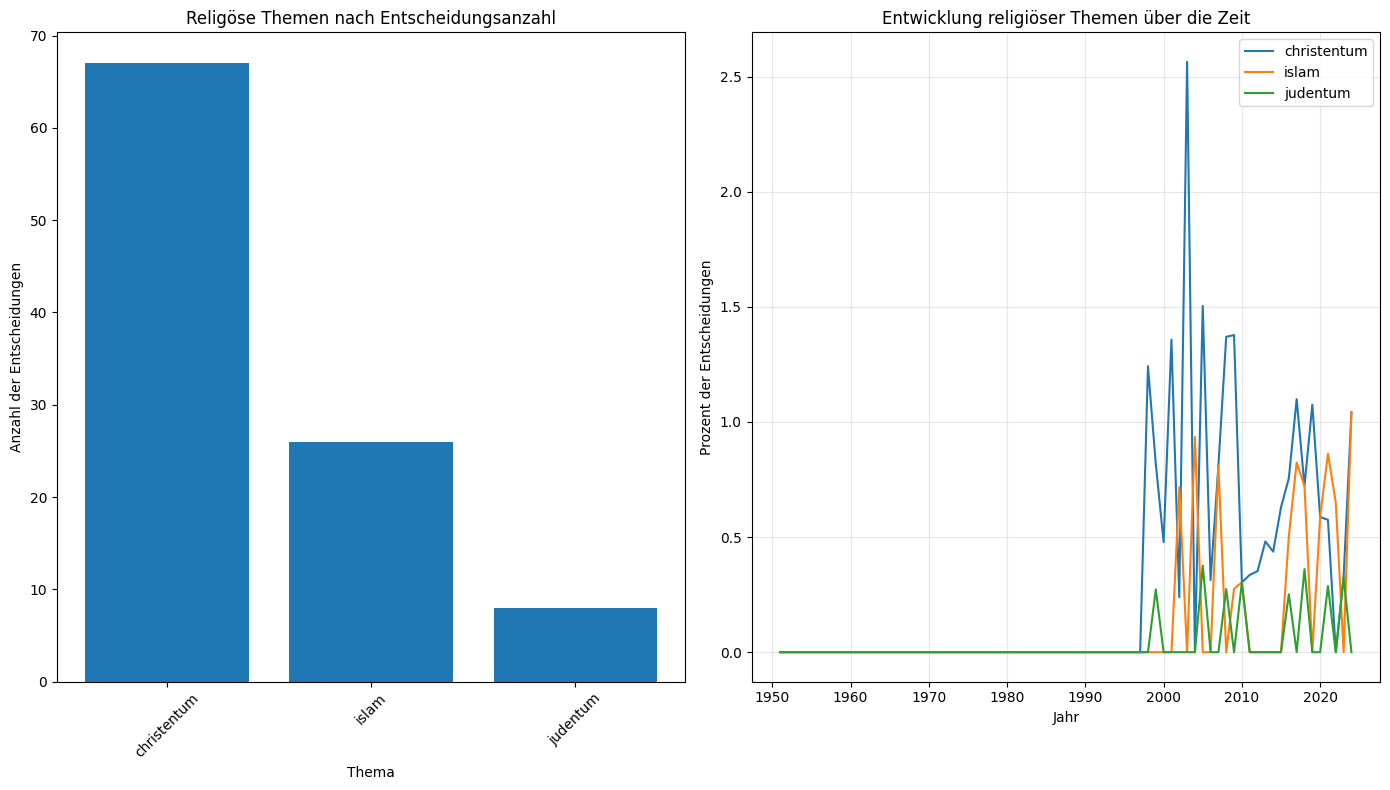

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

absolute_counts = {}
for theme in religion_themes.keys():
    absolute_counts[theme] = df[f'has_{theme}'].sum()

axs[0].bar(absolute_counts.keys(), absolute_counts.values())
axs[0].set_title('Religöse Themen nach Entscheidungsanzahl')
axs[0].set_xlabel('Thema')
axs[0].set_ylabel('Anzahl der Entscheidungen')
axs[0].tick_params(axis='x', rotation=45)


for theme in religion_themes.keys():
    theme_by_year = df.groupby('entscheidungsjahr')[f'has_{theme}'].mean() * 100
    axs[1].plot(theme_by_year.index, theme_by_year.values, label=theme)

axs[1].set_title('Entwicklung religiöser Themen über die Zeit')
axs[1].set_xlabel('Jahr')
axs[1].set_ylabel('Prozent der Entscheidungen')
axs[1].grid(True, alpha=0.3)
axs[1].legend()


plt.tight_layout()
plt.show()


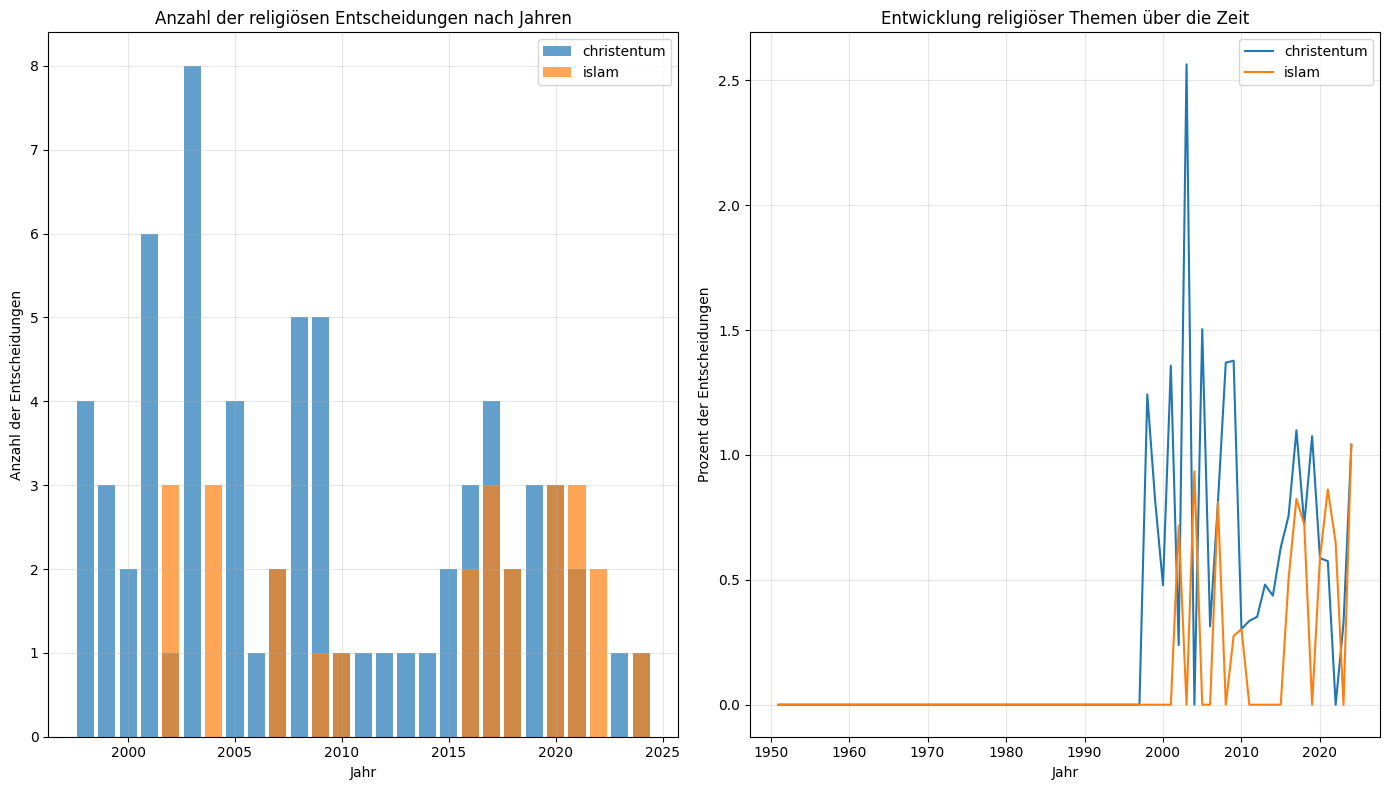

In [25]:
selected_religions = {k: v for k, v in religion_themes.items() if k in ['islam', 'christentum']}
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# Absolute count of all decisions that year with that theme
for theme in selected_religions.keys():
    theme_counts = df[df[f'has_{theme}'] == 1].groupby('entscheidungsjahr').size()
    axs[0].bar(theme_counts.index, theme_counts.values, alpha=0.7, label=theme)

axs[0].set_title('Anzahl der religiösen Entscheidungen nach Jahren')
axs[0].set_xlabel('Jahr')
axs[0].set_ylabel('Anzahl der Entscheidungen')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# relative decision count of that year
for theme in selected_religions.keys():
    theme_by_year = df.groupby('entscheidungsjahr')[f'has_{theme}'].mean() * 100
    axs[1].plot(theme_by_year.index, theme_by_year.values, label=theme)
axs[1].set_title('Entwicklung religiöser Themen über die Zeit')
axs[1].set_xlabel('Jahr')
axs[1].set_ylabel('Prozent der Entscheidungen')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()

Von religions-spezifischen Urteilen können wir besonders einen Einstieg der islamisch-betreffenden Urteile erkennen, als auch einen Abstieg von christlich-bezogenen Urteilen. 

In [26]:
df.columns

Index(['text', 'url_html', 'clean_w_numbers', 'gesetzesverweise',
       'clean_wo_numbers', 'datum', 'entscheidungsjahr', 'entscheidung_typ',
       'spruchkoerper_typ', 'registerzeichen', 'richter',
       'processed_wo_numbers', 'text_lemma', 'religious_terms_count',
       'religious_terms_detail', 'has_religious_content', 'has_christentum',
       'has_islam', 'has_judentum'],
      dtype='object')

In [27]:
religious_df = df[df['has_religious_content'] == True]
law_refs = religious_df['gesetzesverweise'].dropna().apply(ast.literal_eval)
law_refs

120     [Art. 2 Abs. 1 — auch in Verbindung mit Art. 1...
277     [§ 93b in Verbindung mit § 93a BVerfGG, Art. 1...
307     [§ 18 Abs. 4 Satz 1 Halbsatz 2 PartG muss die ...
388                         [§ 93d Abs. 1 Satz 3 BVerfGG]
389                         [§ 93d Abs. 1 Satz 3 BVerfGG]
                              ...                        
8636    [Art. 13 Abs. 1 Satz 1 des mit Zustimmungsgese...
8689    [§ 22 Abs. 3 DRiG, § 339 StGB, § 22 Abs. 3 DRi...
8846    [§ 28a Abs. 1 SGB XII mit der sich nach § 28a ...
8857    [Art. 2 Abs. 1, Art. 3 Abs. 1, Art. 5 Abs. 1, ...
8866    [§ 93a Abs. 2 Buchstabe b BVerfGG, Art. 5 Abs....
Name: gesetzesverweise, Length: 140, dtype: object

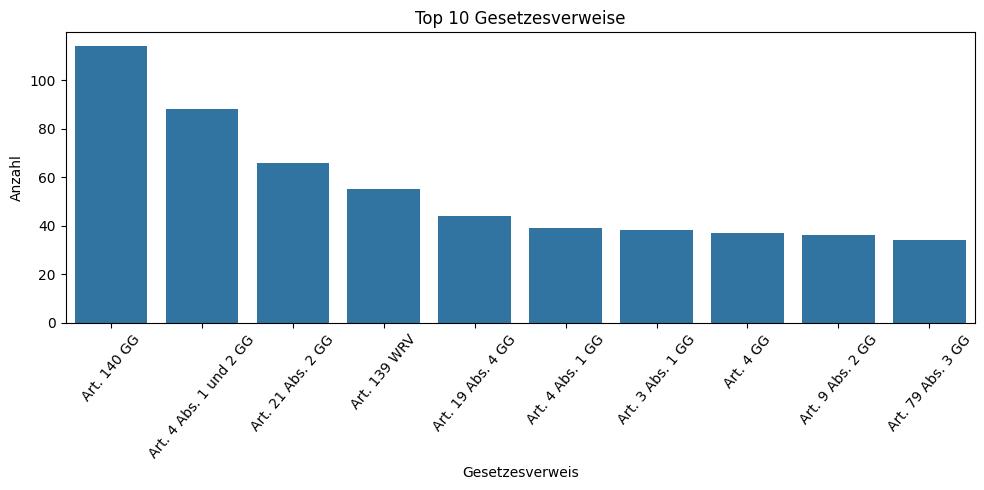

In [28]:
flat_list = [item for sublist in law_refs for item in sublist]
top_list = Counter(flat_list).most_common(10)
top_df = pd.DataFrame(top_list, columns=['gesetzesverweis', 'anzahl'])

plt.figure(figsize=(10, 5))
sns.barplot(x='gesetzesverweis', y='anzahl', data=top_df)
plt.title('Top 10 Gesetzesverweise')
plt.xlabel("Gesetzesverweis")
plt.ylabel("Anzahl")
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [29]:
top_list = Counter(flat_list).most_common(5)
law_liste = []
for law in top_list:
    law_liste.append(law[0])

In [30]:
df_date = religious_df.copy()
df_date = df_date.set_index("datum")

In [31]:
def count_gesetzesverweise(row, gesetz_list):
    count = 0
    if isinstance(row, list):
        for item in row:
            if any(gesetz.lower() in item.lower() for gesetz in gesetz_list):
                count += 1
    elif isinstance(row, str):
        if any(gesetz.lower() in row.lower() for gesetz in gesetz_list):
            count += 1
    return count

for gesetz in law_liste:
    df_date[gesetz] = df_date['gesetzesverweise'].apply(lambda x: count_gesetzesverweise(x, [gesetz]))

<Figure size 1200x600 with 0 Axes>

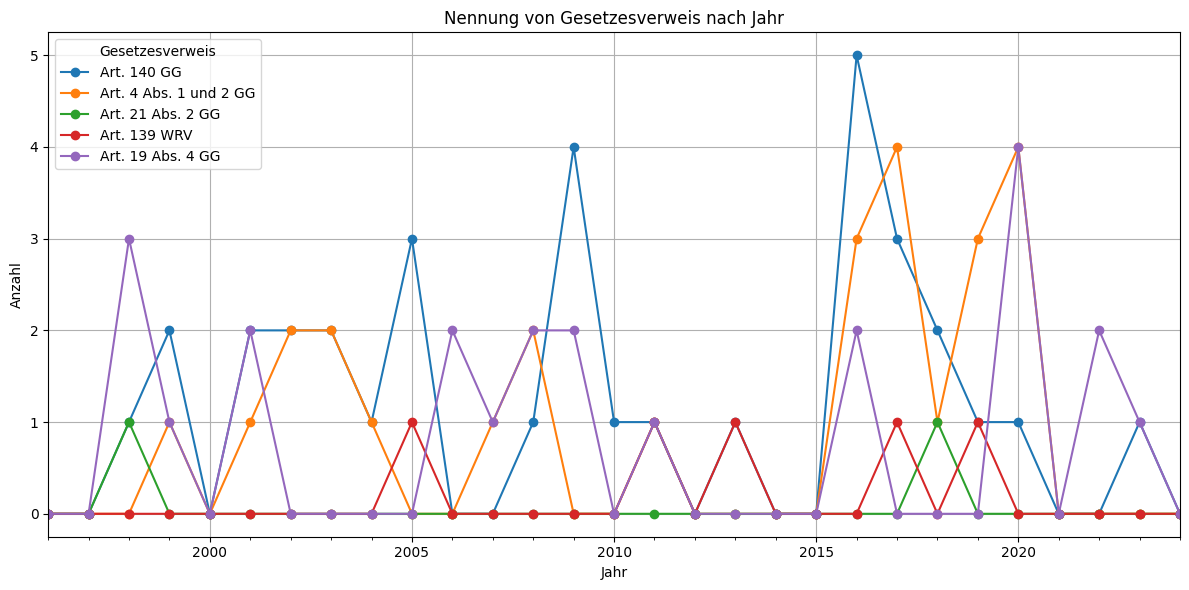

In [32]:
yearly_counts = df_date[law_liste].resample("Y").sum()

# Plot the results
plt.figure(figsize=(12, 6))
yearly_counts.plot(marker='o', figsize=(12, 6))

plt.title("Nennung von Gesetzesverweis nach Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl")
plt.legend(title="Gesetzesverweis", labels=law_liste)
plt.grid(True)
plt.tight_layout()

In religiösen Urteilen sind wie abzusehen, Art. 4 GG, Art. 140 GG in Verbindung mit Art. 139 WRV, oft vermerkt. Dahingegen sind Art. 19 und Art. 21 GG unerwartet, wobei beide vor dem Millenium und in letzteren Jahren relevant zu sein scheinen.

In [34]:
# Visualize top laws by religious theme
law_references_by_theme = {}

for theme in ["has_christentum", "has_islam", "has_judentum"]:
    df_theme = religious_df[religious_df[theme] == 1]
    
    law_refs = df_theme['gesetzesverweise'].dropna().apply(ast.literal_eval)
    flat_list = [item for sublist in law_refs for item in sublist]
    top_laws = Counter(flat_list).most_common(5)
    law_references_by_theme[theme.replace("has_", "").capitalize()] = dict(top_laws)

C:\Users\25mad\AppData\Local\Temp\ipykernel_27104\3326849559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(laws.keys(), rotation=45, ha="right")
C:\Users\25mad\AppData\Local\Temp\ipykernel_27104\3326849559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(laws.keys(), rotation=45, ha="right")
C:\Users\25mad\AppData\Local\Temp\ipykernel_27104\3326849559.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(laws.keys(), rotation=45, ha="right")


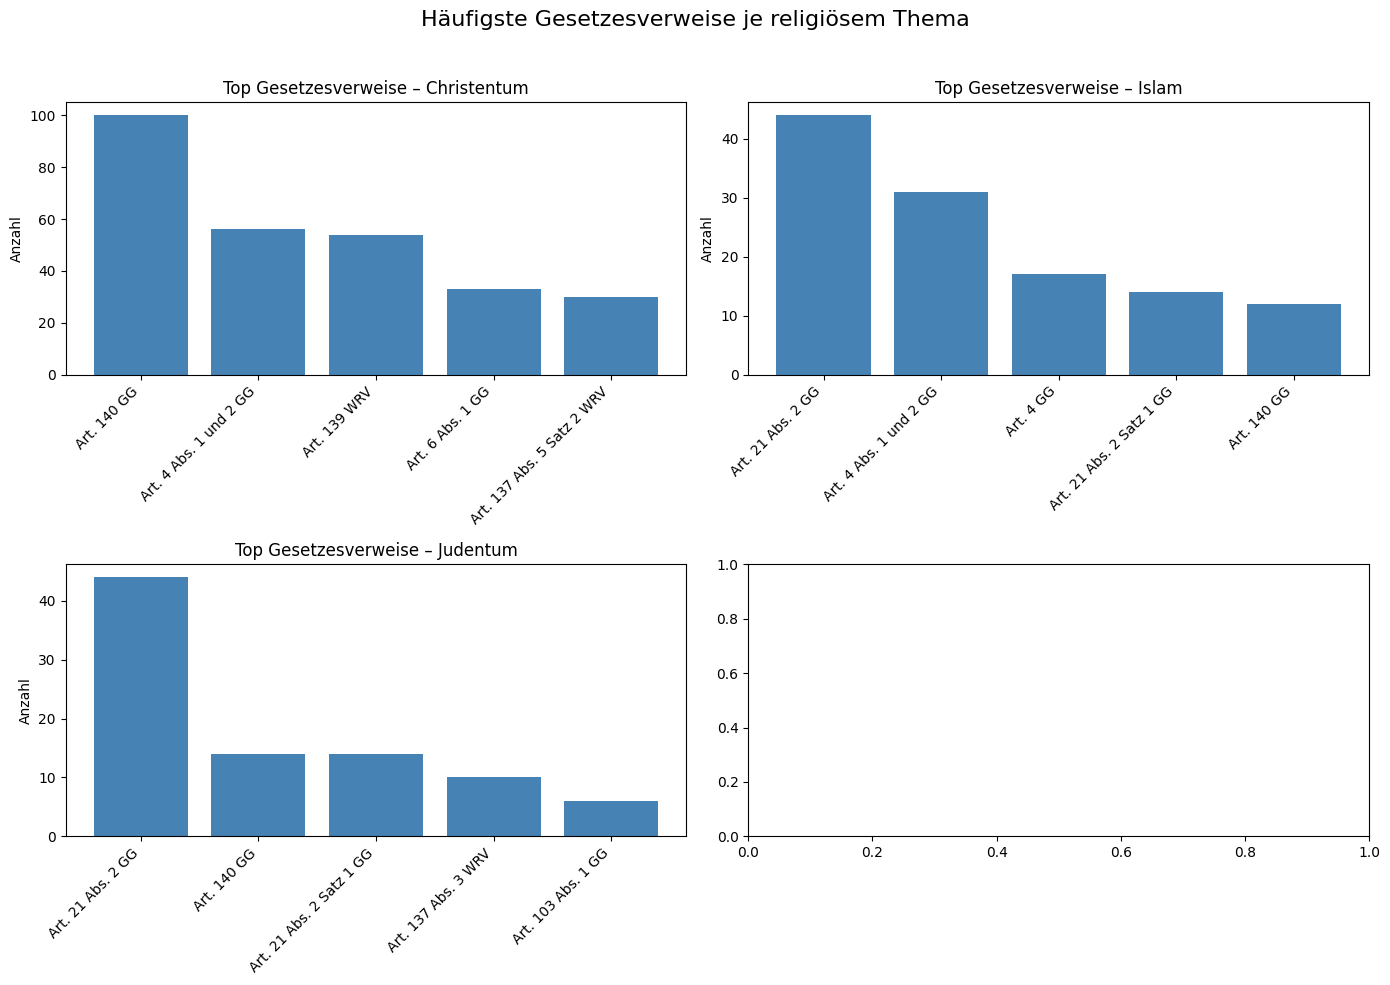

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (theme, laws) in enumerate(law_references_by_theme.items()):
    axs[i].bar(laws.keys(), laws.values(), color="steelblue")
    axs[i].set_title(f"Top Gesetzesverweise – {theme}")
    axs[i].set_ylabel("Anzahl")
    axs[i].set_xticklabels(laws.keys(), rotation=45, ha="right")

plt.suptitle("Häufigste Gesetzesverweise je religiösem Thema", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Hier als Auffälligkeiten sind Art. 21 Abs. 2 GG, die vorwiegend in islamischen oder jüdisch-geprägten Urteilen referenziert werden. Dabei handelt es sich um "(2) Parteien, die nach ihren Zielen oder nach dem Verhalten ihrer Anhänger darauf ausgehen, die freiheitliche demokratische Grundordnung zu beeinträchtigen oder zu beseitigen oder den Bestand der Bundesrepublik Deutschland zu gefährden, sind verfassungswidrig."
- Es scheint also, dass Schwerpunkt der Argumentation in Richtung "Gefährdung" der demokratischen Grundordnung fällt.

### 1.4 Kollokationen und N-Gramme
Um Themen herausfinden zu können, werden im Nachfolgenden Kollokationen und N-Gramme erstellt. 

In [36]:
# Based on first few visualizations remove following from the text_lemma column
filter_list = ["beschwerdeführer", "beschwerdeführerin", "antragsteller", "antragstellerin", "antrag", "erlass", "anordnung",
               "deutsch", "antragsgegnerin", "verfassungsrechtlich", "gesetzgeber", "regelung", "staatlich",
               "entscheidung", "bvr", "artikel", "absatz", "verfassungsbeschwerde", "herr", "bekanntmachung", "einstweilig", "einstimmig",
               "buchstabe", "fassung", "beschließen", "annehmen", "verfahren"
               ]

religious_df.loc[:,"text_lemma_filtered"] = religious_df.loc[:,"text_lemma"].apply(
    lambda text: ' '.join([word for word in text.split() if word.lower() not in filter_list])
)

C:\Users\25mad\AppData\Local\Temp\ipykernel_27104\2432090760.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  religious_df.loc[:,"text_lemma_filtered"] = religious_df.loc[:,"text_lemma"].apply(


In [37]:
corpus = religious_df["text_lemma_filtered"]
tokens = corpus.apply(lambda x: word_tokenize(x))

In [38]:
def plot_mfw(filtered_tokens):
    lst_tokens = [word for sublist in filtered_tokens for word in sublist]

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
    fig.suptitle("Most Frequent Words", fontsize=15)

    ## Unigrams
    dic_words_freq = FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_uni.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Unigrams", ax=ax[0], legend=False, color="steelblue"
    )
    ax[0].set(ylabel=None)

    ## Bigrams
    dic_words_freq = FreqDist(nltk.bigrams(lst_tokens))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(x))
    dtf_bi.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Bigrams", ax=ax[1], legend=False, color="darkorange"
    )
    ax[1].set(ylabel=None)

    ## Trigrams 
    dic_words_freq = FreqDist(nltk.trigrams(lst_tokens))
    dtf_tri = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_tri["Word"] = dtf_tri["Word"].apply(lambda x: " ".join(x))
    dtf_tri.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Trigrams", ax=ax[2], legend=False, color="forestgreen"
    )
    ax[2].set(ylabel=None)

    ## Quadgrams (4-grams)
    dic_words_freq = FreqDist(nltk.ngrams(lst_tokens, 4))
    dtf_quad = pd.DataFrame(dic_words_freq.most_common(10), columns=["Word", "Freq"])
    dtf_quad["Word"] = dtf_quad["Word"].apply(lambda x: " ".join(x))
    dtf_quad.set_index("Word").sort_values(by="Freq").plot(
        kind="barh", title="Quadgrams", ax=ax[3], legend=False, color="purple"
    )
    ax[3].set(ylabel=None)

    plt.tight_layout()
    plt.show()


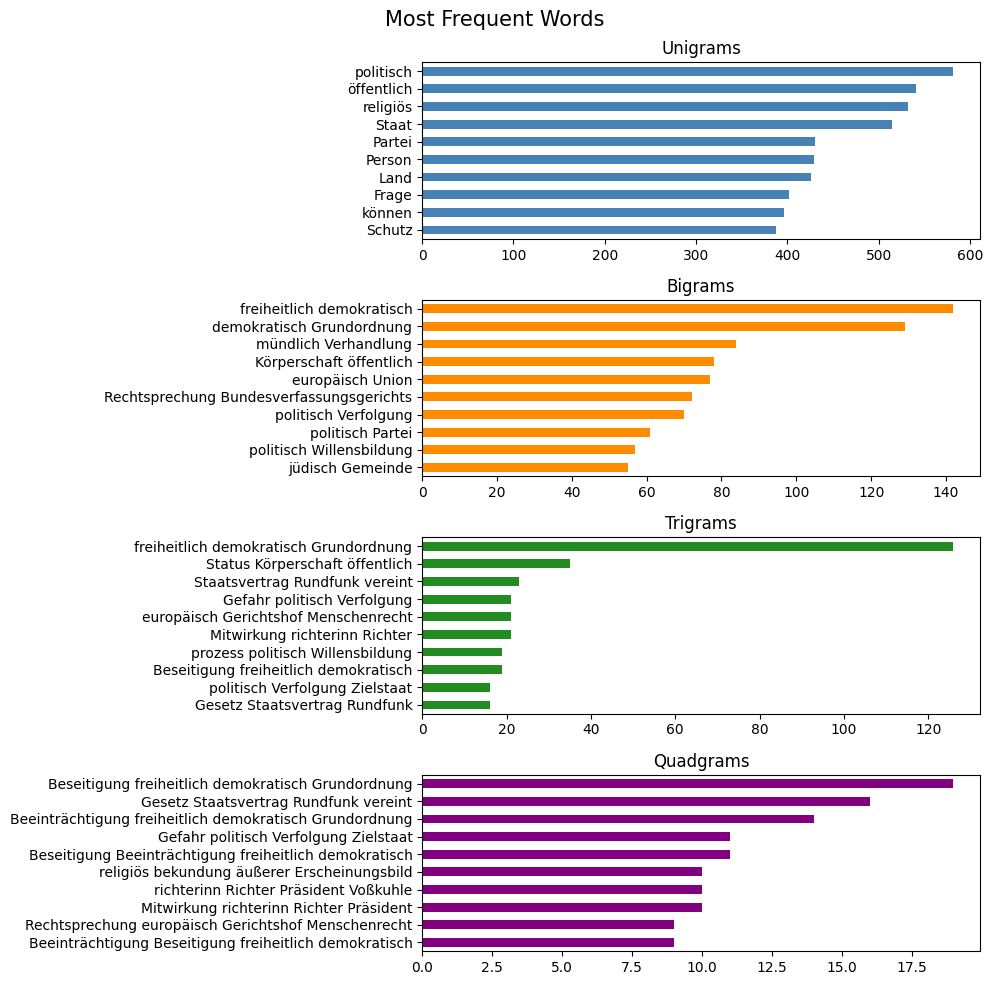

In [39]:
plot_mfw(tokens)

Besonders die 3-grams und 4-grams sind für die Untersuchung von Rechtsprechung interessant. Auffälligkeiten sind dabei insbesondere:
- Bezug auf "(Beeinträchtigung) freiheitlich demokratische Grundordnung"
- "europäisch Gerichtshof Menschenrecht"
- "Verbot geschäftsmäßig Förderung Selbsttötung"
- "Status Körperschaft öffentlich"

In [40]:
# Safe df before continueing:
religious_df.to_csv(r'data\df_religious_prepped.csv', index=False)

In [41]:
df[df['has_religious_content'] == False].to_csv(r'data\df_normal_prepped.csv', index=False)

In [42]:
df.columns

Index(['text', 'url_html', 'clean_w_numbers', 'gesetzesverweise',
       'clean_wo_numbers', 'datum', 'entscheidungsjahr', 'entscheidung_typ',
       'spruchkoerper_typ', 'registerzeichen', 'richter',
       'processed_wo_numbers', 'text_lemma', 'religious_terms_count',
       'religious_terms_detail', 'has_religious_content', 'has_christentum',
       'has_islam', 'has_judentum'],
      dtype='object')